#TODO's: 
1. Set up a virtual enviorment (conda or .venv) 
2. Set up the needed packages 
3. Analize the Dataset
4. look for classification Algorithm
5. Preporcess Dataset
6. Make sure CUDA works
7. Train model with the goal of high recall (because it's a dataset that needs to detect attacks)
8. Look at the performance

In [24]:
#Check GPU
!nvidia-smi

Sun Dec 15 14:55:31 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 566.03                 Driver Version: 566.03         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   40C    P8              6W /   85W |      18MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [25]:
#import the standard libraries for data analysis

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

In [42]:
# ML Libraries
from sklearn.model_selection import train_test_split, GridSearchCV # added for hyperparameter optimization
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    precision_recall_curve,
    f1_score,
    make_scorer,
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer # added to impute missing values, SVC does not handle missing values so gotta fix that error

Data Loading

In [27]:
# Load the dataset to df parameter
df = pd.read_csv('dataset_sdn.csv')

Data Analysis

In [43]:
# Basic information about the dataset
print("Dataset shape: ", df.shape) # rows - data, columns - features
print("\nClass Distribution:")
print(df['label'].value_counts(normalize=True)) # class distribution (0 - benign, 1 - malicious), how many % of each class

print("\nMissing values before cleaning:")
print(df.isnull().sum()) # missing values in the dataset

Dataset shape:  (104345, 23)

Class Distribution:
label
0    0.609143
1    0.390857
Name: proportion, dtype: float64

Missing values before cleaning:
dt               0
switch           0
src              0
dst              0
pktcount         0
bytecount        0
dur              0
dur_nsec         0
tot_dur          0
flows            0
packetins        0
pktperflow       0
byteperflow      0
pktrate          0
Pairflow         0
Protocol         0
port_no          0
tx_bytes         0
rx_bytes         0
tx_kbps          0
rx_kbps        506
tot_kbps       506
label            0
dtype: int64


Visualization Of The Dataset

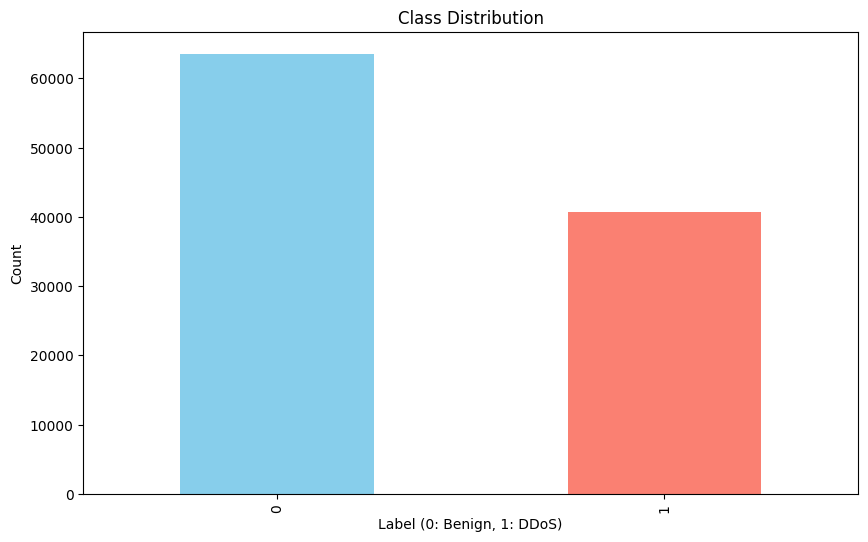

In [29]:
# Here we manually make a plot to show the class distribution
plt.figure(figsize=(10, 6)) # size of the plot
df['label'].value_counts().plot(kind='bar', color=['skyblue', 'salmon']) # bar plot
plt.title('Class Distribution') # title of the plot
plt.xlabel('Label (0: Benign, 1: DDoS)') 
plt.ylabel('Count') 
plt.show()

Feature Selection

In [30]:
features = [
    'pktcount', 'bytecount', 'dur', 'tot_dur', 'flows', 
    'packetins', 'pktperflow', 'byteperflow', 'pktrate', 
    'Pairflow', 'port_no', 'tx_bytes', 'rx_bytes', 
    'tx_kbps', 'rx_kbps', 'tot_kbps'
]

In [31]:
# Prepare x and y
x = df[features]
y = df['label']

In [44]:
# Handle missing values
imputer = SimpleImputer(strategy='mean') # impute missing values with the mean of the column
x = pd.DataFrame(imputer.fit_transform(x), columns=x.columns)

print(x.isnull().sum()) # check if there are any missing values left

pktcount       0
bytecount      0
dur            0
tot_dur        0
flows          0
packetins      0
pktperflow     0
byteperflow    0
pktrate        0
Pairflow       0
port_no        0
tx_bytes       0
rx_bytes       0
tx_kbps        0
rx_kbps        0
tot_kbps       0
dtype: int64


In [ ]:
# Split the data into training and testing sets (with keeping stratification in mind for a balanced class distribution)
x_train, x_test, y_train, y_test = train_test_split(
    x, y, # x - features, y - labels
    test_size=0.2,  # 80% training, 20% testing
    random_state=42, # seed for reproducibility
    stratify=y # keep the class distribution balanced in the training and testing sets (as seen above we have an unbalanced class distribution)
    )

Feature Scaling

In [39]:
# We use standardization for scaling teh numerical features in a range to ease the training process
scaler = StandardScaler() # standardization of the data
x_train_scaled = scaler.fit_transform(x_train) 
x_test_scaled = scaler.transform(x_test) 

Model Training And Evalutaion

In [33]:
# custom scoring function for the F1 score (as we have an unbalanced class distribution)
def balanced_f1(y_true, y_pred): # y_true - true labels / y_pred - predicted labels
    return f1_score(y_true, y_pred, average='weighted')

In [34]:
# models to evaluate
# Addin hyperparameter optimization to the models NOTE: these aren't NN so we do not use epochs, batch size, etc. :,)

# 1. Random Forest with grid search
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': ['balanced']
}

rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=42), # random forest classifier
    rf_params, # parameters to optimize
    cv=3, # 3-fold cross-validation
    scoring='f1'
    n_jobs=-1 # use all available cores
)

print("\nTraining Random Forest...")
rf_grid.fit(x_train_scaled, y_train)
print("Best Random Forest parameters:", rf_grid.best_params_)

# 2. Support Vector Machine with grid search
svm_params = {
    'C': [0.1, 1, 10],
    'kernel': ['rbf'],
    'class_weight': ['balanced']
}

svm_grid = GridSearchCV(
    SVC(random_state=42, probability=True), # support vector machine classifier
    svm_params, # parameters to optimize
    cv=3, # 3-fold cross-validation
    scoring='f1',
    n_jobs=-1 # use all available cores
)

print("\nTraining SVM...")
svm_grid.fit(x_train_scaled, y_train)
print("Best SVM parameters:", svm_grid.best_params_)

# 3. Logistic Regression with grid search
lr_params = {
    'C': [0.1, 1, 10],
    'penalty': ['balanced'],
    'max_iter': [1000]
}

lr_gird = GridSearchCV(
    LogisticRegression(random_state=42), 
    lr_params,
    cv=3, 
    scoring='f1',
    n_jobs=-1 
)

print("\nTraining Logistic Regression...")
lr_grid.fit(X_train_scaled, y_train)
print("Best Logistic Regression parameters:", lr_grid.best_params_)


In [41]:
# Evaluation Results
results = {}


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12712
           1       1.00      1.00      1.00      8157

    accuracy                           1.00     20869
   macro avg       1.00      1.00      1.00     20869
weighted avg       1.00      1.00      1.00     20869



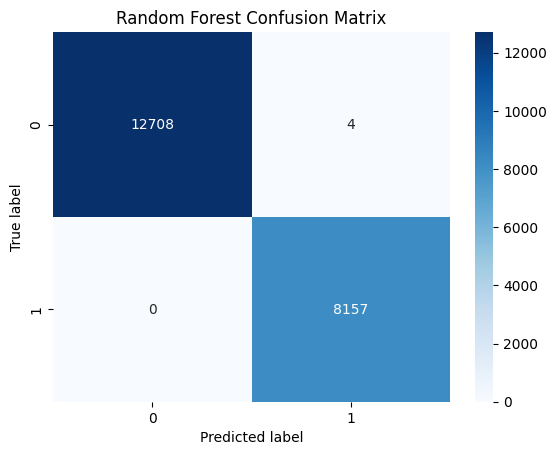

ValueError: Input X contains NaN.
SVC does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [36]:
# Evaluate each model
for name, model in models.items():
   # fit the model on the training data
   model.fit(x_train_scaled, y_train) 

   # Predict the test data
   y_pred = model.predict(x_test_scaled)

   # Detailed classification report
   print(f'\n{name} Classification Report:')
   report = classification_report(y_test, y_pred)
   print(report) 

   # Confusion Matrix
   cm = confusion_matrix(y_test, y_pred)
   sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
   plt.title(f'{name} Confusion Matrix')
   plt.xlabel('Predicted label')
   plt.ylabel('True label')
   plt.show()

   # store the results
   results[name] = {
       'classification_report': report,
       'confusion_matrix': cm
   }




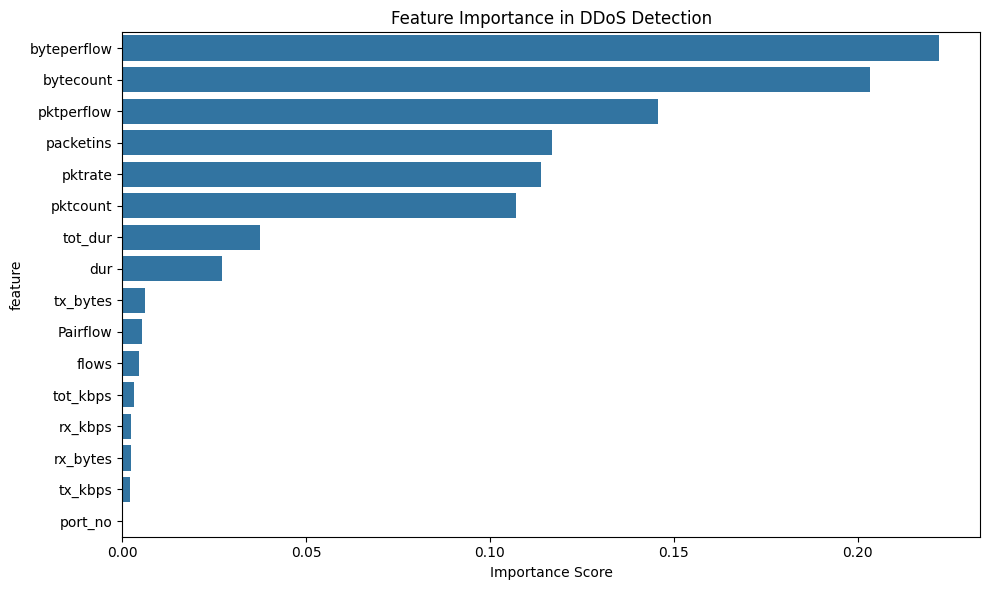

In [37]:
# Feature Importance (for Random Forest)

rf_model = models['Random Forest']
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance in DDoS Detection')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

Precision-Recall Curve

In [ ]:
plt.figure(figsize=(10, 6))
for name, model in models.items():
    # Predict probabilities
    y_scores = model.predict_proba(x_test_scaled)[:, 1]
    
    # Compute precision-recall curve
    precision, recall, _ = precision_recall_curve(y_test, y_scores)
    
    # Plot the curve
    plt.plot(recall, precision, label=name)

plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.tight_layout()
plt.show()

NameError: name 'X_test_scaled' is not defined

<Figure size 1000x600 with 0 Axes>